# Along track interpolation

! pip install cartopy

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

Cloning into 'GPSat'...
remote: Enumerating objects: 2667, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 2667 (delta 212), reused 320 (delta 210), pack-reused 2338
Receiving objects: 100% (2667/2667), 56.65 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (1824/1824), done.
Updating files: 100% (125/125), done.
changing directory to: /content/GPSat


In [3]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Windows"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8

In [4]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GPSat


In [5]:
import os
import re
import glob
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from datetime import datetime, timedelta
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.postprocessing import smooth_hyperparameters
import GPSat
from GPSat.postprocessing import glue_local_predictions_1d
from GPSat.postprocessing import glue_local_predictions_2d


def GCdist(X,Xs):
    radius = lambda lat : np.sqrt(((6378137**2 * np.cos(lat))**2 + (6356752**2 * np.sin(lat))**2/\
                                  (6378137 * np.cos(lat))**2 + (6356752 * np.sin(lat))**2))

    minlat = min(np.min(X.T[(1,)].T),np.min(Xs.T[(1,)].T))
    maxlat = max(np.max(X.T[(1,)].T),np.max(Xs.T[(1,)].T))
    lon1 = np.radians(X.T[(0,)].T) ; lat1 = np.radians(X.T[(1,)].T)
    lon2 = np.radians(Xs.T[(0,)].T) ; lat2 = np.radians(Xs.T[(1,)].T)
    r = 6356752#np.mean(radius(np.arange(minlat,maxlat)))

    Clat1 = np.cos(lat1) ; Clat2 = np.cos(lat2)
    Slat1 = np.sin(lat1) ; Slat2 = np.sin(lat2)
    Clon1 = np.cos(lon1) ; Clon2 = np.cos(lon2)
    Slon1 = np.sin(lon1) ; Slon2 = np.sin(lon2)

    n1 = np.array([Clat1*Clon1,Clat1*Slon1,Slat1]).T
    n2 = np.array([Clat2*Clon2,Clat2*Slon2,Slat2]).T
    return r*np.arccos(np.dot(n1,n2.T))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [7]:
#indices for GPOD data:
#0 = Lon
#1 = Lat
#2 = Interpolated SLA
#3 = Error in interpolated SLA
#4 = Freeboard
#5 = Pulse Peakiness
#6 = Lew
#7 = Class (1=Lead, 2=Floe, 3=OO)
#8 = Sigma 0
#9 = Raw Elevation
#10 = Mean Sea-surface
#11 = SIC
#12 = Sea ice type (0=FYI, 1=MYI)
#13 = Snow depth
#14 = Snow density
#15 = Sea ice thickness
#16 = GPOD SLA
#17 = GPOD SSH
#18 = GPOD SWH
#19 = Elevation from Samosa

interp_date = datetime(2019,1,15)
grab_dates = sorted([interp_date-timedelta(days=x) for x in range(5)]+[interp_date+timedelta(days=x) for x in range(1,5)])
grab_dates = [x.strftime('%Y%m%d') for x in grab_dates]

x = []
y = []
t = []
lon = []
lat = []
dates = []
classif = []
interpSLA = []
elev = []
satellite = []
trackID = []

# dirs = sorted(glob.glob('/Users/wg4031/Dropbox/GPOD_DATA/*'))
dirs = sorted(glob.glob('/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/GPOD/*'))
count = 0
for directory in dirs:
    tracks = sorted(glob.glob(directory+'/*v1.proc'))
    SAT = directory.split('/')[-1]
    if (SAT == 'SARIN') or (SAT == 'SAR'):
    # if (SAT == 'CS2_SARIN') or (SAT == 'CS2_SAR'):
        SAT = 'CS2'
        for track in tracks:
            date = track.split('/')[-1].split('T')[0].split('_')[-1]
            if date in grab_dates:
                time = 14975 + (datetime(int(date[:4]),int(date[4:6]),int(date[6:8]))-datetime(2011,1,1)).days
                f = np.genfromtxt(track)

                ID = np.where((f[:,7]<3) & (f[:,11]>=0.75))[0]
                classes = np.copy(f[ID,7]).astype(str)
                classes[classes=='1.0'] = 'lead'
                classes[classes=='2.0'] = 'floe'
                elvmss = f[ID,9]-f[ID,10]
                elvmss[classes=='floe'] = elvmss[classes=='floe']-0.1626 #subtract 16.26cm bias (see Lawrence et al., 2019)

                xg,yg = WGS84toEASE2_New(f[ID,0],f[ID,1])
                N = len(xg)
                x.extend(xg)
                y.extend(yg)
                t.extend([time]*N)
                lon.extend(f[ID,0])
                lat.extend(f[ID,1])
                dates.extend([date]*N)
                classif.extend(classes)
                interpSLA.extend(f[ID,2])
                elev.extend(elvmss)
                satellite.extend([SAT]*N)
                trackID.extend([count]*N)
                count += 1

    elif (SAT == 'S3A'):
    # if (SAT == 'CS2_SARIN') or (SAT == 'CS2_SAR'):
        SAT = 'S3A'
        for track in tracks:
            date = track.split('/')[-1].split('T')[0].split('_')[-1]
            if date in grab_dates:
                time = 14975 + (datetime(int(date[:4]),int(date[4:6]),int(date[6:8]))-datetime(2011,1,1)).days
                f = np.genfromtxt(track)

                ID = np.where((f[:,7]<3) & (f[:,11]>=0.75))[0]
                classes = np.copy(f[ID,7]).astype(str)
                classes[classes=='1.0'] = 'lead'
                classes[classes=='2.0'] = 'floe'
                elvmss = f[ID,9]-f[ID,10]
                elvmss[classes=='floe'] = elvmss[classes=='floe']-0.1626 #subtract 16.26cm bias (see Lawrence et al., 2019)

                xg,yg = WGS84toEASE2_New(f[ID,0],f[ID,1])
                N = len(xg)
                x.extend(xg)
                y.extend(yg)
                t.extend([time]*N)
                lon.extend(f[ID,0])
                lat.extend(f[ID,1])
                dates.extend([date]*N)
                classif.extend(classes)
                interpSLA.extend(f[ID,2])
                elev.extend(elvmss)
                satellite.extend([SAT]*N)
                trackID.extend([count]*N)
                count += 1

    elif (SAT == 'S3B'):
    # if (SAT == 'CS2_SARIN') or (SAT == 'CS2_SAR'):
        SAT = 'S3B'
        for track in tracks:
            date = track.split('/')[-1].split('T')[0].split('_')[-1]
            if date in grab_dates:
                time = 14975 + (datetime(int(date[:4]),int(date[4:6]),int(date[6:8]))-datetime(2011,1,1)).days
                f = np.genfromtxt(track)

                ID = np.where((f[:,7]<3) & (f[:,11]>=0.75))[0]
                classes = np.copy(f[ID,7]).astype(str)
                classes[classes=='1.0'] = 'lead'
                classes[classes=='2.0'] = 'floe'
                elvmss = f[ID,9]-f[ID,10]
                elvmss[classes=='floe'] = elvmss[classes=='floe']-0.1626 #subtract 16.26cm bias (see Lawrence et al., 2019)

                xg,yg = WGS84toEASE2_New(f[ID,0],f[ID,1])
                N = len(xg)
                x.extend(xg)
                y.extend(yg)
                t.extend([time]*N)
                lon.extend(f[ID,0])
                lat.extend(f[ID,1])
                dates.extend([date]*N)
                classif.extend(classes)
                interpSLA.extend(f[ID,2])
                elev.extend(elvmss)
                satellite.extend([SAT]*N)
                trackID.extend([count]*N)
                count += 1



df = pd.DataFrame({'x':np.array(x),'y':np.array(y),'t':np.array(t),'lon':np.array(lon),'lat':np.array(lat),'date':np.array(dates),
                  'elevation':elev,'interpSLA':np.array(interpSLA),'class':np.array(classif),
                  'SAT':np.array(satellite),'track':np.array(trackID)})

df

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
0,-3.056178e+06,-1.270463e+06,17907,-67.427184,60.000844,20190111,0.4397,NaN,lead,S3A,0
1,-3.055943e+06,-1.270243e+06,17907,-67.429148,60.003653,20190111,0.4250,0.4207,lead,S3A,0
2,-3.055707e+06,-1.270022e+06,17907,-67.431112,60.006463,20190111,0.4296,0.4201,lead,S3A,0
3,-3.055472e+06,-1.269801e+06,17907,-67.433077,60.009272,20190111,0.4494,0.4195,lead,S3A,0
4,-3.055236e+06,-1.269580e+06,17907,-67.435042,60.012081,20190111,0.4171,0.4190,lead,S3A,0
...,...,...,...,...,...,...,...,...,...,...,...
2063569,-1.099325e+06,3.126184e+05,17915,-105.874325,79.752732,20190119,0.2087,-0.0866,floe,CS2,877
2063570,-1.099022e+06,3.125989e+05,17915,-105.877535,79.755398,20190119,-0.1044,NaN,lead,CS2,877
2063571,-1.098114e+06,3.125402e+05,17915,-105.887172,79.763397,20190119,0.2351,NaN,floe,CS2,877
2063572,-1.097811e+06,3.125207e+05,17915,-105.890387,79.766064,20190119,0.3295,NaN,floe,CS2,877


In [ ]:
import pandas as pd

savepath = '/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/'

# Assuming all_data_df is your DataFrame
df.to_csv(savepath+'df_GPOD.csv', index=False)

In [ ]:
import pandas as pd

# savepath = '/Users/wg4031/Downloads/'
savepath = '/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/'

# Load DataFrame from CSV file
# df = pd.read_csv(savepath+'all_data_01.csv')
df = pd.read_csv(savepath+'df_GPOD.csv')

# Select profile for interpolation

In [8]:
df['track']

0            0
1            0
2            0
3            0
4            0
          ... 
2063569    877
2063570    877
2063571    877
2063572    877
2063573    877
Name: track, Length: 2063574, dtype: int64

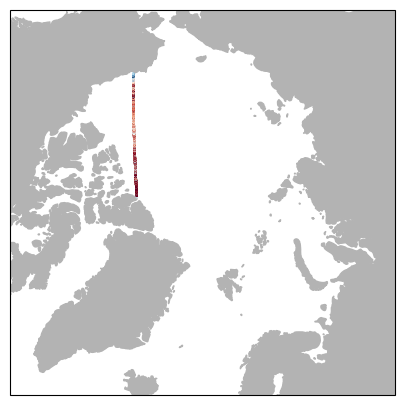

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
293032,-9.647215e+05,8.001362e+04,17911,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
293033,-9.657332e+05,9.735208e+04,17911,-95.756335,81.300914,20190115,-0.2707,-0.1441,lead,S3A,136
293034,-9.658105e+05,9.868576e+04,17911,-95.834190,81.299013,20190115,NaN,-0.1451,floe,S3A,136
293035,-9.658492e+05,9.935263e+04,17911,-95.873106,81.298057,20190115,0.0723,-0.1456,floe,S3A,136
293036,-9.658685e+05,9.968607e+04,17911,-95.892562,81.297578,20190115,0.3727,-0.1458,floe,S3A,136
...,...,...,...,...,...,...,...,...,...,...,...
296847,-1.006973e+06,1.866945e+06,17911,-151.658943,70.913814,20190115,-0.1308,NaN,floe,S3A,136
296848,-1.006953e+06,1.868595e+06,17911,-151.680544,70.900700,20190115,-0.1692,NaN,floe,S3A,136
296849,-1.006950e+06,1.868925e+06,17911,-151.684861,70.898077,20190115,-0.1565,NaN,floe,S3A,136
296850,-1.006946e+06,1.869255e+06,17911,-151.689177,70.895454,20190115,-0.0730,NaN,floe,S3A,136


In [9]:
interptrack = 136 #track on interp day 20190115
df_val = df.loc[df['track']==interptrack]


fig,ax = plt.subplots(1,figsize=(5,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180,180,65,90],ccrs.PlateCarree())
ax.add_feature(cfeat.LAND, color=(0.7,0.7,0.7))
ax.scatter(df_val['lon'],df_val['lat'],s=0.5,c=df_val['elevation'],cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
plt.show()

df_val

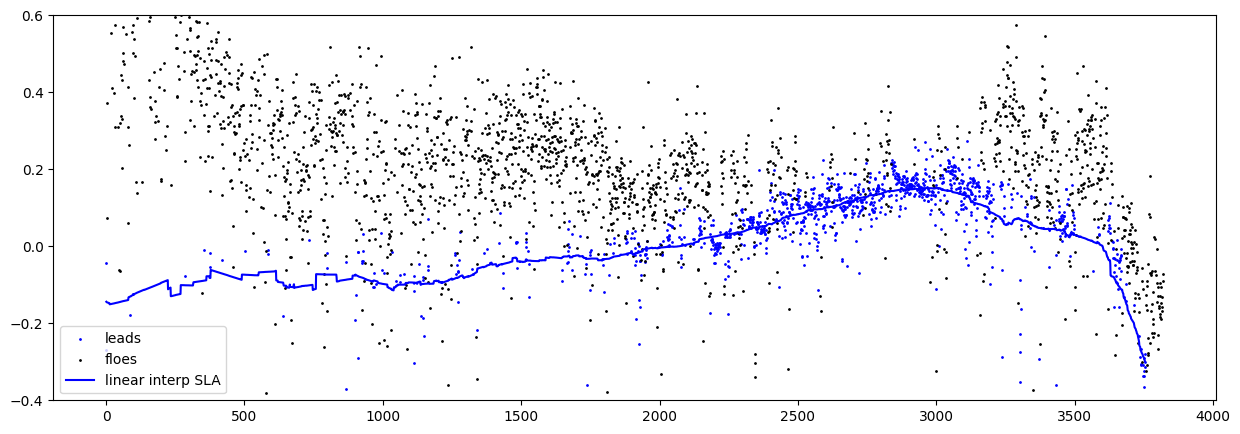

In [10]:
leads = np.where(df_val['class'] == 'lead')
floes = np.where(df_val['class'] == 'floe')
fig,ax = plt.subplots(1,figsize=(15,5))
ax.scatter(leads,df_val['elevation'].iloc[leads],color='b',s=1,label='leads')
ax.scatter(floes,df_val['elevation'].iloc[floes],color='k',s=1,label='floes')
ax.plot(np.arange(len(df_val['interpSLA'])),df_val['interpSLA'],color='b',label='linear interp SLA')
ax.set_ylim(-0.4,0.6)
ax.legend()
plt.show()

# Generate expert locations at 200 km

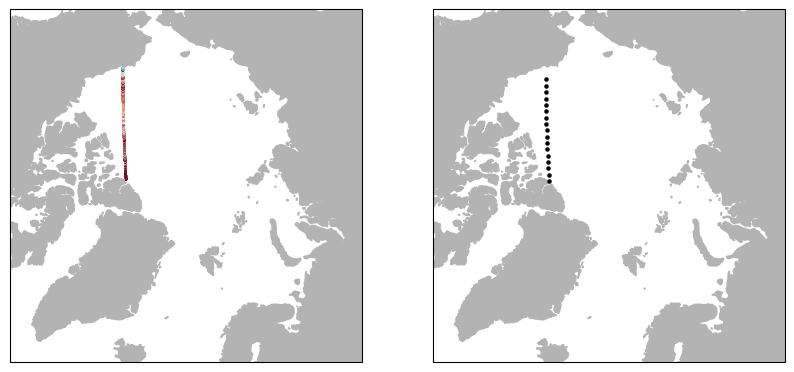

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
293032,-9.647215e+05,8.001362e+04,17911,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
293257,-9.704333e+05,1.807138e+05,17911,-100.548776,81.152823,20190115,NaN,-0.1112,floe,S3A,136
293540,-9.757493e+05,2.814191e+05,17911,-106.088264,80.897666,20190115,NaN,-0.0741,floe,S3A,136
293787,-9.806846e+05,3.824547e+05,17911,-111.305158,80.564322,20190115,NaN,-0.1113,floe,S3A,136
294032,-9.852062e+05,4.831453e+05,17911,-116.123339,80.162816,20190115,0.2475,-0.0977,floe,S3A,136
294244,-9.893178e+05,5.834831e+05,17911,-120.531395,79.701889,20190115,-0.1234,-0.0940,floe,S3A,136
294488,-9.930581e+05,6.844599e+05,17911,-124.576343,79.184512,20190115,0.1136,-0.0422,floe,S3A,136
294743,-9.963981e+05,7.854005e+05,17911,-128.246582,78.620875,20190115,0.2212,-0.0261,floe,S3A,136
294948,-9.993285e+05,8.859638e+05,17911,-131.558885,78.019570,20190115,0.1093,-0.0169,floe,S3A,136
295163,-1.001861e+06,9.864750e+05,17911,-134.556649,77.384464,20190115,0.1629,0.0107,floe,S3A,136


In [11]:
#divide track into 200 km points for expert locations
Xs = np.array([df_val['lon'],df_val['lat']]).T
r_exp = GCdist(Xs,Xs) #compute distance matrix
exp_grid = np.arange(0,np.sum(r_exp[0,:]),100e3)
locs = []
for ix in exp_grid:
    temp = np.abs(r_exp[0,:]-ix)
    dm = np.where(temp==np.min(temp))
    if len(locs)<=16:
        locs.append(dm[0][0])

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-180,180,65,90],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND, color=(0.7,0.7,0.7))
    if c == 0:
        ax[c].scatter(df_val['lon'],df_val['lat'],c=df_val['elevation'],s=0.5,cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(df_val['lon'].iloc[locs],df_val['lat'].iloc[locs],s=5,c='k',transform=ccrs.PlateCarree())
plt.show()

experts = df_val.iloc[locs]
experts

In [ ]:
df_val

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
293032,-9.647215e+05,8.001362e+04,17911,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
293033,-9.657332e+05,9.735208e+04,17911,-95.756335,81.300914,20190115,-0.2707,-0.1441,lead,S3A,136
293034,-9.658105e+05,9.868576e+04,17911,-95.834190,81.299013,20190115,NaN,-0.1451,floe,S3A,136
293035,-9.658492e+05,9.935263e+04,17911,-95.873106,81.298057,20190115,0.0723,-0.1456,floe,S3A,136
293036,-9.658685e+05,9.968607e+04,17911,-95.892562,81.297578,20190115,0.3727,-0.1458,floe,S3A,136
...,...,...,...,...,...,...,...,...,...,...,...
296847,-1.006973e+06,1.866945e+06,17911,-151.658943,70.913814,20190115,-0.1308,NaN,floe,S3A,136
296848,-1.006953e+06,1.868595e+06,17911,-151.680544,70.900700,20190115,-0.1692,NaN,floe,S3A,136
296849,-1.006950e+06,1.868925e+06,17911,-151.684861,70.898077,20190115,-0.1565,NaN,floe,S3A,136
296850,-1.006946e+06,1.869255e+06,17911,-151.689177,70.895454,20190115,-0.0730,NaN,floe,S3A,136


# Interpolate along-track

In [15]:
#WHERE TO SAVE
# store_path = get_parent_path("/Users/wg4031/Dropbox/", "GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5")
store_path = get_parent_path("/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/", "GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5")


#SET PARAMETERS OF MODEL (e.g., use data within 300 km and +/- 4 days)
data = {
    "data_source": df.loc[(df['class']=='lead') & (np.abs(df['elevation'])<0.6) & (~np.isnan(df['elevation']))],
    "obs_col": "elevation",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<=",
            "val": 100_000
        },
        {
            "col": "t",
            "comp":"<=",
            "val":2
        },
        {
            "col": "t",
            "comp":">=",
            "val":-2
        }
    ],
    "global_select": [
        {
            "col": "lat",
            "comp": ">=",
            "val": 45
        }
    ]
}

#GIVE DATAFRAME OF EXPERTS
local_expert = {
    "source": experts
}

#GIVE DATAFRAME OF PREDICTION LOCATIONS (predict at all lead and floe locations along track)
pred_loc = {
    "method": "from_dataframe",
    "df": df_val,
    "max_dist": 200_000
}


#SETUP SPARSE GP MODEL (PLAY WITH MINIBATCH AND INDUCING POINTS)
model = {
    # "oi_model": "GPflowSVGPModel",
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [10000, 10000, 1],
        "minibatch_size": 100,
        "num_inducing_points":200
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        "lengthscales": {
            "low": [100_000, 100_000, 1e-08],
            # "low": [5_000, 5_000, 1e-08],
            "high": [200000, 200000, 4]
            },
            "likelihood_variance": {
                "low": 0.01,
                "high": 10
        }
    }
}

locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True)

#SMOOTH HYPERPARMETERS
smooth_configs = {"lengthscales": dict(l_x=200_000, l_y=200_000, max=12),
                  "likelihood_variance": dict(l_x=200_000, l_y=200_000),
                  "kernel_variance": dict(l_x=200_000, l_y=200_000, max=0.1)}

smooth_hyperparameters(result_file=store_path,
                       params_to_smooth=["lengthscales", "kernel_variance", "likelihood_variance"],
                       smooth_config_dict=smooth_configs,
                       save_config_file=False)

# %%
# ---
# Make predictions with smoothed hyperparameters
# ---
model['load_params'] = {"file": store_path, "table_suffix": "_SMOOTHED"}
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

locexp.run(store_path=store_path,
           optimise=False,
           predict=True,
           table_suffix='_SMOOTHED')

with pd.HDFStore(store_path) as store:
    store.remove('inducing_mean')
    store.remove('inducing_mean_SMOOTHED')
    store.remove('inducing_chol')
    store.remove('inducing_chol_SMOOTHED')
    store.remove('inducing_points')
    store.remove('inducing_points_SMOOTHED')

os.system('ptrepack --chunkshape=auto --propindexes --complib=blosc '+store_path+' temp_store_3D.csv')
os.system('rm '+store_path)
os.system('mv temp_store_3D.csv '+store_path)

print('Done!')

'data_select': 0.000 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 933261 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 3820 >  100
storing as str
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 17
current local expert:
                    x             y      t        lon        lat      date  \
293032 -964721.476545  80013.622113  17911 -94.741238  81.324207  20190115   

        elevation  interpSLA class  SAT  track  
293032    -0.0435        NaN  lead  S3A    136  
'data_select': 0.274 seconds
'load': 0.386 seconds
'local_data_select': 0.366 seconds


KeyError: 'No object named inducing_mean in the file'

In [16]:
# extract, store in dict

store_path = "/content/drive/MyDrive/Teaching_Michel/GEOL0069/StudentFolder/Week_8/GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5"
dfs, _ = GPSat.local_experts.get_results_from_h5file(store_path)

reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
table: 'oi_config_SMOOTHED' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations


In [17]:
from GPSat.postprocessing import glue_local_predictions

In [18]:
preds_data = dfs["preds_SMOOTHED"]

preds_data.head()

,x,y,t,_dim_0,f*,f*_var,y_var,f_bar,pred_loc_x,pred_loc_y,pred_loc_t,lon,lat,date,elevation,interpSLA,class,SAT,track
0,-964721.476545,80013.622113,17911.0,0,-0.119196,0.003131,0.023131,0,-964721.476545,80013.622113,17911.0,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
1,-964721.476545,80013.622113,17911.0,1,-0.132373,0.002399,0.022399,0,-965733.180581,97352.081316,17911.0,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
2,-964721.476545,80013.622113,17911.0,2,-0.133488,0.002370,0.022370,0,-965810.511997,98685.757156,17911.0,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
3,-964721.476545,80013.622113,17911.0,3,-0.134043,0.002357,0.022357,0,-965849.158887,99352.629960,17911.0,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136
4,-964721.476545,80013.622113,17911.0,4,-0.134320,0.002351,0.022351,0,-965868.475571,99686.068297,17911.0,-94.741238,81.324207,20190115,-0.0435,NaN,lead,S3A,136


In [19]:
preds_data['pred_loc_x'].shape

(13984,)

In [20]:
distance_expert=np.sqrt((preds_data['x']-preds_data['x'][0])**2+(preds_data['y']-preds_data['y'][0])**2)

In [21]:
preds_data['xprt_locs']=distance_expert

In [23]:
distance_expert.shape

(13984,)

In [24]:
distance=np.sqrt((preds_data['pred_loc_x']-preds_data['pred_loc_x'][0])**2+(preds_data['pred_loc_y']-preds_data['pred_loc_y'][0])**2)

In [25]:
preds_data['pred_locs']=distance

In [ ]:
# # multiple local experts may make predictions at the same prediction location (pred_loc).
# # - for each prediction at a given location, take we weighted combination
# # - weights being a function of the distance to each local expert that made a prediction at a given location.

# inference_radius = 200_000  # 200km
# plt_data = glue_local_predictions_2d(preds_df=preds_data,
#                                      pred_loc_cols=["pred_loc_x", "pred_loc_y"],
#                                      xprt_loc_cols=["x", "y"],
#                                      vars_to_glue=["f*", "f*_var"],
#                                      inference_radius=inference_radius)



In [28]:
inference_radius = 200_000  # 200km

glued_preds = glue_local_predictions_1d(preds_df = preds_data,                  # The dataframe where results are stored
                                        pred_loc_col = 'pred_locs',             # The column in dataframe corresponding to the prediction locations
                                        xprt_loc_col = 'xprt_locs',             # The column in dataframe corresponding to the local expert locations
                                        vars_to_glue=["f*", "f*_var"],          # The columns in dataframe corresponding to the predictions
                                        inference_radius = inference_radius)    # The inference radius (by passing a single float, it is assumed to be equal for both regions)


In [29]:
glued_preds

,pred_locs,f*,f*_var
0,0.000000e+00,-0.114224,0.003273
1,1.736795e+04,-0.126856,0.002586
2,1.870387e+04,-0.127944,0.002556
3,1.937186e+04,-0.128480,0.002543
4,1.970586e+04,-0.128746,0.002537
...,...,...,...
3815,1.787431e+06,-0.051931,0.009066
3816,1.789080e+06,-0.051383,0.009216
3817,1.789410e+06,-0.051273,0.009245
3818,1.789740e+06,-0.051162,0.009275


In [31]:
glued_preds['f*'].shape

(3820,)

In [32]:
df_val['interpSLA'].shape

(3820,)

In [ ]:
leads

(array([   0,    1,   88, ..., 3753, 3754, 3755]),)

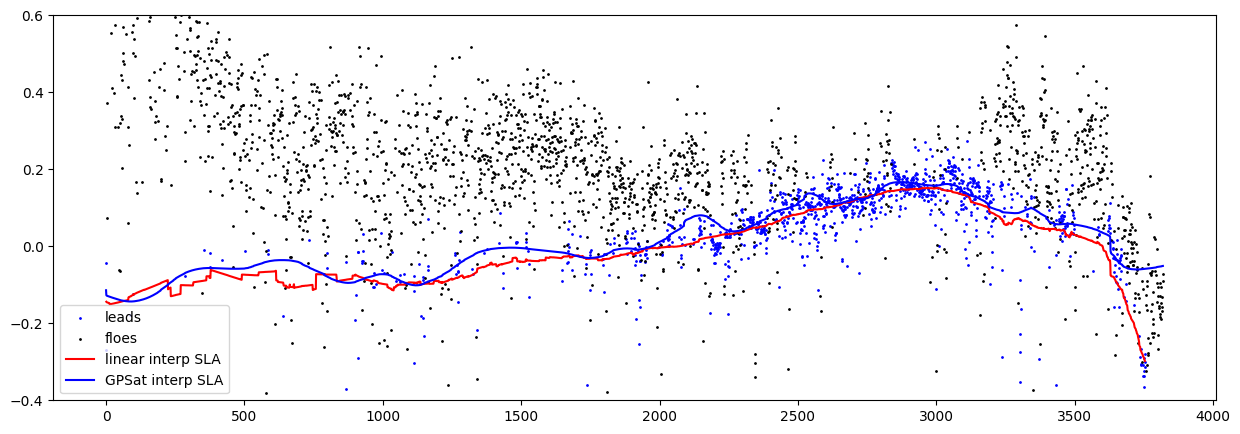

In [33]:
leads = np.where(df_val['class'] == 'lead')
floes = np.where(df_val['class'] == 'floe')
fig,ax = plt.subplots(1,figsize=(15,5))
ax.scatter(leads,df_val['elevation'].iloc[leads],color='b',s=1,label='leads')
ax.scatter(floes,df_val['elevation'].iloc[floes],color='k',s=1,label='floes')
ax.plot(np.arange(len(df_val['interpSLA'])),df_val['interpSLA'],color='r',label='linear interp SLA')
ax.plot(np.arange(len(df_val['interpSLA'])),glued_preds['f*'],color='b',label='GPSat interp SLA')
ax.set_ylim(-0.4,0.6)
ax.legend()
plt.show()